# Text analysis with Airline tweets

First we'll import the pandas library and read in our csv that has a collection of tweets regarding different airlines.

In [7]:
import pandas as pd
airline_tweets = pd.read_csv("Tweets.csv")

Let's inspect the data frame called "airline_tweets" and see the different variables

In [ ]:
airline_tweets

We need to first create variables that will hold the variables of interest.

In this case, we want to use the tweet's text to predict the sentiment of the tweet.

That is, can we tell if the tweet is positive or negative automatically, just by the text.

These tweets have already been tagged as positive, negative, and neurtal, so we can use that information to train the tweets.

In the code below, we create a variable called "sentiment" that holds the sentiment of each positive or negative tweet.

We then create a variable called "text" that holds the text of the tweet

In [65]:
# Identify the variables of interest
#Focus only on the positive and negative tweets: not neutral
sentiment = airline_tweets.airline_sentiment[(airline_tweets.airline_sentiment != "neutral")]
text = airline_tweets.text[(airline_tweets.airline_sentiment != "neutral")]

# Process the text

Our next step is to process the text and get it in a correct format for analysis.

The first thing we'll do is lowercase all of the text by using the .str.lower() function from the pandas data Series

## Lowercase the text

In [66]:
text = text.str.lower()
print text.head(5)

1    @virginamerica plus you've added commercials t...
3    @virginamerica it's really aggressive to blast...
4    @virginamerica and it's a really big bad thing...
5    @virginamerica seriously would pay $30 a fligh...
6    @virginamerica yes, nearly every time i fly vx...
Name: text, dtype: object


## Remove stopwords

Next, we'll remove words that are probably not relevant to the tweet's sentiment, and might lead to overfitting.

These words are called stopwords and they are conjunctions, articles, prepositions, and other function words in speech.

We'll import a stopword list from sklearn.

Then well make a function that filters out an word that is in the stopword list.

Notice the content.split() function.

That breaks our text apart into it's separate words

After we've filter out the words, we'll join it back to a string and return the cleaned text

Finally, we'll apply the function to every single row in our text data Series

In [67]:
# Make a list of the words you want remove# Remove stop words

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# Remove stop words
def remove_stopwords(content):
    cleaned = filter(lambda x: x not in ENGLISH_STOP_WORDS,content.split())
    return ' '.join(cleaned)
#Apply the function to every row
text = text.apply(remove_stopwords)

print text.head(5)

1    @virginamerica plus you've added commercials e...
3    @virginamerica it's really aggressive blast ob...
4             @virginamerica it's really big bad thing
5    @virginamerica seriously pay $30 flight seats ...
6    @virginamerica yes, nearly time fly vx “ear wo...
Name: text, dtype: object


## Remove Punctuation and Numbers

We'll remove punctuation from the tweets so that the punctuation isn't counted in the word.

We'll apply our remove_punctuation function to each row of the data Series

In [68]:
import string
def remove_punctuation(content):
    return filter(lambda x: x in string.ascii_letters+" ",content)
text = text.apply(remove_punctuation)
print text.head(5)

1    virginamerica plus youve added commercials exp...
3    virginamerica its really aggressive blast obno...
4               virginamerica its really big bad thing
5    virginamerica seriously pay  flight seats didn...
6    virginamerica yes nearly time fly vx ear worm ...
Name: text, dtype: object


## Reduce words to their word stems

Finaly, we'll make all of our words word stems, so that, for example, see, sees, and seeing all become "see"

We are going to use the Porter Stemmer algorithm from the porter stemmer library. For every word in our document's content, we'll apply the stem function to it, and then rejoin the words as a string.

This stemming function is applied to every row in the data frame

In [223]:
# Stemming
import porterstemmer
stemmer = porterstemmer.PorterStemmer()
def stem_words(content):
    stemmed_words = [stemmer.stem(word, 0,len(word)-1) for word in content.split()]
    return " ".join(stemmed_words)

stemmed_text = text.apply(stem_words)
stemmed_text.head(5)

1                                        virginamerica plu youv ad commerci experi tacki
3    virginamerica it realli aggress blast obnoxi entertain guest face amp littl recours
4                                                  virginamerica it realli big bad thing
5            virginamerica serious pai flight seat didnt plai it realli bad thing fly va
6                                 virginamerica ye nearli time fly vx ear worm wont awai
Name: text, dtype: object

The NLTK library also has a stemmer function. If you have nltk installed, you can run the function using the following code

In [225]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def stem_words(content):
    stemmed_words = [stemmer.stem(word) for word in content.split()]
    return " ".join(stemmed_words)
stem_words("happy birthday")

u'happi birthday'

## Train a classifier

Now that we have a data Series with the text exactly as we want it, we can turn our text into a Document X Term using a CountVectorizer that we will fit (to learn the vocabulary) and transform on our text (to make a Document X Term matrix)

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
counts = count_vect.fit_transform(text)

In [ ]:
Our Document X Term Matrix is stored in a sparse array to make it efficiently held in memory

In [30]:
counts

<11541x12152 sparse matrix of type '<type 'numpy.int64'>'
	with 112005 stored elements in Compressed Sparse Row format>

We can use the tfidf transformer to take our counts and make it into a Document X Term Matrix with tfidf values in the cells

In [71]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(counts)
tf_idf = tf_transformer.transform(counts)

Although the matrix is in a sparse form, we can use the .todense() function to make it into a normal matrix with values for every cell

In [72]:
tf_idf.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Now that we have a matrix of our predictors (the tfidf values for each word-stem), we can enter them into a classifier.

We'll use a Naive Bayes classifier, which is common for text classification, and predicts a category by assigning a probability to each word.

We'll score the accuracy of what the classifier predicts and what the sentiment actually is.

In [73]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(tf_idf, sentiment)
clf.score(tf_idf,sentiment)

0.87488085954423356

Let's look at the confusion matrix to see how our true positive, true negative, false positive, and false negative rate is

In [74]:
from sklearn.metrics import confusion_matrix
sentiment_predictions = clf.predict(tf_idf)
cm = confusion_matrix(sentiment,sentiment_predictions)
print cm

[[9172    6]
 [1438  925]]


We can visualize the confusion matrix as a heatmap

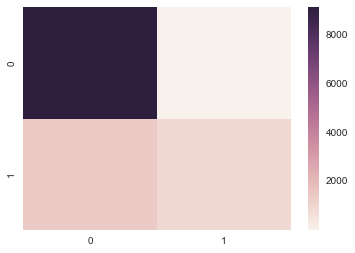

In [75]:
import seaborn
% matplotlib inline
seaborn.heatmap(cm)

If we wanted to adjust the rate of false positives and false negatives, we can use the class-prior parameter in the naive bayes classifier to make predictions of a certain class more likely

0.9214972706
[[8546  632]
 [ 274 2089]]


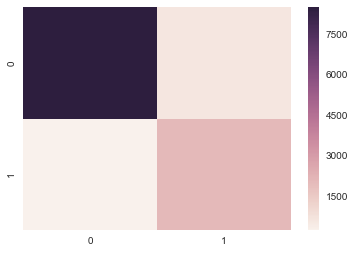

In [95]:
clf = MultinomialNB(class_prior=[.4,.6]).fit(tf_idf, sentiment)
print clf.score(tf_idf,sentiment)
sentiment_predictions = clf.predict(tf_idf)
cm = confusion_matrix(sentiment,sentiment_predictions)
print cm
seaborn.heatmap(cm)

## Try with a Support Vector Machine

Another common classifier is a support vector machine.

These classifiers tend to work well when there are many predictors such as our current matrix which has counts for all of the words

0.999566761979
[[9177    1]
 [   4 2359]]


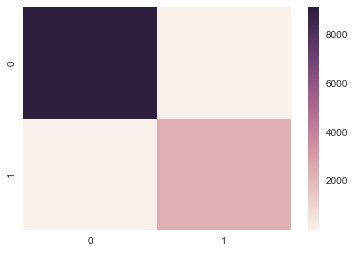

In [120]:
from sklearn.svm import SVC
clf = SVC(C=10,gamma=1)
clf.fit(tf_idf, sentiment)
print clf.score(tf_idf,sentiment)
sentiment_predictions = clf.predict(tf_idf)
cm = confusion_matrix(sentiment,sentiment_predictions)
print cm
seaborn.heatmap(cm)

We can use our predictions list to isolate just the texts are predicted to be positive and see what they say

In [123]:
text[(sentiment_predictions == "positive")].sample(10)

889                                     united great fares
8677      jetblue yes yes does great trip down thanks lift
6502        southwestair timeand just time flight thursday
12595    americanair gerrielliott will chance get thank...
5463               southwestair fortunemagazine great news
2896                        thank united prompt assistance
6597     southwestair great flight amp crew las vegasch...
6975     jetblue excited hear international travel long...
8633     jetblue handled xjareds question like social m...
9145     usairways great crew flight  phx yvr tonight f...
Name: text, dtype: object

Likewise, we can do the same for tweets predicted to be negative

In [124]:
text[(sentiment_predictions == "negative")].sample(10)

4661     southwestair can doesnt fair bags need fit sea...
7689     jetblue doing horrible job jfkyou need rethink...
10740    usairways again flight week delayed  mins thin...
12524    americanair pity machine replied story unusual...
3261     united direct phone number status match desk r...
10818    usairways ive tried calling  times past  days ...
11649    usairways did wont help cant believe wouldnt f...
13424    americanair talked anyone guys prepared situat...
7314     jetblue concerned delay notified looked board ...
9725     usairways delayed  hours longbeachairport tryi...
Name: text, dtype: object

# Topic Analysis

Let's try to identify the underlying reasons or topics for negative complaints.

We'll make a variable that just holds the negative reviews and make a Document X Term tfidf weighted matrix from those

In [233]:
from sklearn.decomposition import LatentDirichletAllocation

negative_reviews = text[(sentiment == 'negative')]
count_vect = CountVectorizer()
counts = count_vect.fit_transform(negative_reviews)

Next, we'll fit a Latent Dirilecht Allocation model to the matrix, and say that we expect there to about 5 reasons (an arbritrary number basedon an educated guess).

We'll also say to have a maximum of 10 iterations when fitting the model to give the model more time to try to find the best topic distributions. The downside of a larger iteration number is that it takes more time to run.

In [234]:
n_topics = 5
lda = LatentDirichletAllocation(n_topics=n_topics,max_iter=10)
lda.fit(counts)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_jobs=1, n_topics=5, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

We can discover what the topics represent by printing out the top 10 words associated with each.

Try to think about what each topic means based on the words

In [237]:
n_top_words = 10
import operator
vocabulary = count_vect.get_feature_names()
for i in range(n_topics):
    best_words_indexes = lda.components_[i].argsort()[:-n_top_words - 1:-1]
    best_words = " ".join([vocabulary[i] for i in best_words_indexes])
    print best_words

united jetblue service customer americanair southwestair plane usairways delay dont
americanair flight united usairways im time late delayed hours just
usairways hold thanks worst help minutes weather change phone thats
jetblue issue refund pay united whats answer speak understand better
flight cancelled southwestair usairways flightled airport help united need flights


We can see how each document scored on each topic using the transform function on our lda model class.

We'll call each topic "topic1" "topic2" etc.

In [235]:
n_topics = 5
topic_assignments = lda.transform(counts)
topic_names = ["topic%s" % i for i in range(1,n_topics+1)]
topic_assignments = pd.DataFrame(topic_assignments,range(counts.shape[0]), topic_names)

Larger values mean that the document is more about that topic

In [231]:
topic_assignments

,topic1,topic2,topic3,topic4,topic5
0,0.202320,0.200276,7.191488,0.201795,0.204120
1,0.202925,1.203036,11.185380,0.205008,0.203651
2,6.190344,0.200101,0.204148,0.202359,0.203048
3,6.163506,0.200042,0.203825,0.205135,7.227492
4,0.202124,0.200113,0.202143,8.024803,2.370818
5,0.201840,0.200254,0.200622,4.194497,0.202788
6,0.202890,0.200074,2.078666,1.544722,4.973647
7,7.197838,0.200133,0.200276,0.200609,0.201143
8,0.200828,0.200038,0.201670,0.205320,13.192143
9,12.176550,0.200081,0.205894,0.215192,0.202283


We can see what are the tweets that scored most highly on a certain topic (e.g., topic1).

The code below sorts the topic assignments by their score on topic 1, then gets the top 10 indexes.

We'll make the pandas column width larger to be able to read the tweets.

Finally, we'll take the indexes of the top 10 tweets and index our main text column

In [236]:
topic1_top10 = topic_assignments.sort_values(by='topic1',ascending = False).index[:10]
pd.set_option('max_colwidth', 100)
print negative_reviews.iloc[topic1_top10]

1565                  united ua heading gate bc improper load ur packing gills care load bags expecting comp
259      virginamerica requested window seat confirmed window got stuck middle seat good way treat silver...
10817    usairways know like gate x nationalairpor  nothini like nothin bout yo ghettofab gate usairways ...
24       virginamerica guys messed seating reserved seating friends guys gave seat away   want free internet
633                   united way simple apology goes long way its hollow one its obvious dont care wellbeing
13252    americanair united just deplaned ohare gate k dont send customer service rep discuss situation g...
997      united guy really customer service cluecould spent effort clearing bins rollerboards instead art...
9162     usairways instead fair treatment got nasty letter lady senior management illness forfeits miles ...
1543     united truly drunk uncle boarding dont believe gate agent overhead full dont reserve aisle httpt...
2414               

In [216]:
pd.set_option('max_colwidth', 800)

Does that topic seem to match with your personal guess of what the topic was? 

You can see what the different coded topics were and see if they match up to the topic assignments

In [222]:
airline_tweets['negativereason'].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems', 'Lost Luggage',
       'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)